## Prepare the data

### 1. Load the fine-tuning data

In [1]:
import json

file_path = "/Users/vasuhiteshi/Documents/llm/fine_tuning.json"
with open(file_path, "r") as file:
    data = json.load(file)

### 2. Load the tokenizer

In [2]:
import sys
sys.path.append('..')

In [3]:
from minbpe import RegexTokenizer

tokenizer = RegexTokenizer()
tokenizer.load(model_file="/Users/vasuhiteshi/Documents/llm/tokenizer/my_tokenizer.model")


def get_vocab_size(tokenizer: RegexTokenizer) -> int:
    vocab = tokenizer.vocab
    special_tokens = tokenizer.special_tokens

    return len(vocab) + len(special_tokens)

### 3. Tokenize the sequences

In [4]:
tokenized_data = []
for item in data:
    tokenized_item = tokenizer.encode(item, allowed_special="all")
    tokenized_data.append(tokenized_item)

len(tokenized_data[0])

134

### 4. Split the data

We need to be careful when splitting the data. We want to keep the multi-turn conversations complete in each part. So, the training and validation sets should start with a `You` message and end with an `Assistant` message.

In [5]:
initial_split_index = int(0.95 * len(data))

# Adjusting the index to ensure that the training set ends with "Assistant" message
# and that the validation set starts with "You" message

# Scanning backward to find an Assistant message
split_index = initial_split_index
while split_index > 0 and not data[split_index-1].startswith('<|startoftext|>Person 2'):
    split_index -= 1

train_data = data[:split_index]
val_data = data[split_index:]

print("Training set: ")
print(f"Start message: {train_data[0].split('<|separator|>')[0]}")
print(f"End message: {train_data[-1].split('<|separator|>')[0]}")

print("\nValidation set: ")
print(f"Start message: {val_data[0].split('<|separator|>')[0]}")
print(f"End message: {val_data[-1].split('<|separator|>')[0]}")

Training set: 
Start message: <|startoftext|>Person 1
End message: <|startoftext|>Person 2

Validation set: 
Start message: <|startoftext|>Person 1
End message: <|startoftext|>Person 1


We got the index that we should use to split the data. Now, let's split the tokenized data.

In [6]:
train_data = tokenized_data[:split_index]
val_data = tokenized_data[split_index:]

Now, we need to combine the `You` and `Assistant` turns into one sequence. We will make sure that the resulting sequence does not exceed the `block_size`.

In [7]:
block_size = 256


def combine_turns(data: list[list[int]], should_trim_long_sequences: bool) -> list[list[int]]:
    combined_turns_data = []
    for i in range(0, len(data)-1, 2):
        you_message = data[i]
        assistant_message = data[i+1]
        if not you_message or not assistant_message:
            continue

        final_message = you_message + assistant_message
        if len(final_message) > block_size and should_trim_long_sequences:
            final_message = final_message[-block_size:]

        combined_turns_data.append(final_message)
    return combined_turns_data


combined_train_data = combine_turns(
    data=train_data,
    should_trim_long_sequences=True
)
combined_val_data = combine_turns(
    data=val_data,
    should_trim_long_sequences=True
)

In [8]:
print("Train data")
print(f"Length before: {len(train_data)}")
print(f"Length after: {len(combined_train_data)}")

print("\nValidation data")
print(f"Length before: {len(val_data)}")
print(f"Length after: {len(combined_val_data)}")

Train data
Length before: 48
Length after: 24

Validation data
Length before: 3
Length after: 1


We will merge the `You` and `Assistant` parts into one sequence. Then, we will try to combine multiple sequences of `You` and `Assistant` into a single input, but only if the sequence length stays smaller than the block size.

In [9]:
def merge_conversation_turns(combined_data: list[list[int]], block_size: int) -> list[list[int]]:
    new_data = []
    current_sequence = []

    for sequence in combined_data:
        if len(current_sequence) + len(sequence) <= block_size:
            current_sequence.extend(sequence)
        else:
            if current_sequence:
                new_data.append(current_sequence)
            current_sequence = sequence.copy()

    # Add the last block if it's not empty
    if current_sequence:
        new_data.append(current_sequence)

    return new_data


merged_train_data = merge_conversation_turns(
    combined_data=combined_train_data,
    block_size=block_size
)
merged_val_data = merge_conversation_turns(
    combined_data=combined_val_data,
    block_size=block_size
)

In [10]:
len(combined_train_data), len(merged_train_data)

(24, 10)

Let's convert each sequence of tokens into a tensor.

In [11]:
import torch

train_data = torch.tensor(combined_train_data)
val_data = torch.tensor(combined_val_data)

ValueError: expected sequence of length 203 at dim 1 (got 166)

Since our token sequences don't all have the same length, we can't turn the data into a tensor all at once. To do that, all sequences need to have the same length.

That's why we need to use padding to fix this problem. We can add padding at the start or end of the sequence. Let's add it to the start.

In [11]:
import torch
torch.manual_seed(3647)

# The token `<|padding|>` is used to mask the padding tokens.
# Masking means the model will ignore these tokens during training.
# In other words, the loss will not be calculated for these tokens.
padding_token = tokenizer.special_tokens["<|padding|>"]


def apply_padding_to_data(data: list[list[int]], block_size: int, padding_token: int) -> torch.Tensor:
    tensors = []
    for i in range(len(data)):
        tensor = torch.tensor(data[i])
        padded_tensor = torch.nn.functional.pad(
            input=tensor,
            # for right padding:
            pad=(0, block_size - len(tensor)),
            # pad=(block_size - len(tensor), 0),
            value=padding_token
        )
        tensors.append(padded_tensor)

    return torch.stack(tensors)


train_data_tensor = apply_padding_to_data(
    data=merged_train_data,
    block_size=block_size,
    padding_token=padding_token
)
val_data_tensor = apply_padding_to_data(
    data=merged_val_data,
    block_size=block_size,
    padding_token=padding_token
)

train_data_tensor.shape, val_data_tensor.shape

(torch.Size([10, 256]), torch.Size([1, 256]))

In [12]:
train_data_tensor[0]

tensor([1024,   80,  282,  115,  286,   32,   49, 1025,   72,  101,  121,   10,
         567,  119,   32,  288,  101,   32,  893,   63,   10,   91,   50,   54,
          47,   48,   50,   47,   50,   48,   50,   53,   44,   32,   57,   58,
          49,   56,   32,   65,   77,   93,   32,  126,   32,   80,  282,  115,
         286,   32,   50,   58,   32,   72,  101,  121,   33,   32,   73,  329,
         109,   32,  103,  320,  100,   44,   32,  119,  522,   32,  386,  295,
         116,   32,  893,   63,   10,   91,   50,   54,   47,   48,   50,   47,
          50,   48,   50,   53,   44,   32,   57,   58,   50,   48,   32,   65,
          77,   93,   32,  126,   32,   80,  282,  115,  286,   32,   49,   58,
          32,   73,  329,  109,   32,  103,  320,  100,   32,  289,  111,   44,
          32,  106,  327,  116,   32,   97,   32,   98,  336,   32,  307,  298,
         100, 1026, 1024,   80,  282,  115,  286,   32,   50, 1025,   76,  286,
         103,   32,  445,  409,  116,   

In [14]:
val_data_tensor[0]

tensor([1024,   80,  282,  115,  286,   32,   49, 1025,   89,  295,   32,  415,
         298,   63,   32,   73,   32,  801,   32,  100,  365,  559,   32,  105,
         102,   32,  893,  329,  298,   32,  307,  298,  100, 1026, 1024,   80,
         282,  115,  286,   32,   50, 1025,   78,   97,  104,   44,   32,   73,
          32,  644,  116,   32,  272,  342, 1026, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028, 1028,
        1028, 1028, 1028, 1028, 1028, 10

### 5. Creat the data loaders

In [13]:
from typing import Tuple
from torch.utils.data import Dataset, DataLoader


class FineTuningDataset(Dataset):
    def __init__(self, data: torch.Tensor, device: torch.device, padding_token: int):
        self.data = data  # shape: (num_samples, block_size)
        self.device = device
        self.padding_token = padding_token

    def __len__(self) -> int:
        return len(self.data)

    def __getitem__(self, index: int) -> Tuple[torch.Tensor, torch.Tensor]:
        sample = self.data[index]
        x = sample.to(self.device)
        y = sample[1:].to(self.device)
        padding_tensor = torch.tensor([self.padding_token], device=self.device)
        y = torch.cat((y, padding_tensor))
        return x, y


batch_size = 32
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataset = FineTuningDataset(
    data=train_data_tensor,
    device=device,
    padding_token=padding_token
)
train_loader = DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True
)

val_dataset = FineTuningDataset(
    data=val_data_tensor,
    device=device,
    padding_token=padding_token
)
val_loader = DataLoader(
    dataset=val_dataset,
    batch_size=batch_size,
    shuffle=False
)

In [14]:
x, y = next(iter(train_loader))
x.shape, y.shape

(torch.Size([10, 256]), torch.Size([10, 256]))

## Fine-tuning

### 1. Load the saved checkpoint

In [15]:
from transformer.model import GPTLanguageModel

block_size = 256
n_embd = 256
n_head = 8
n_layer = 4
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)

model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)
model = torch.compile(model)

print(sum(p.numel() for p in model.parameters())/1e6, 'M parameters')

3.752458 M parameters


In [18]:
import torch
from transformer.model import GPTLanguageModel

# --- Tokenizer setup (Assuming you already have it) ---
# tokenizer = ...
# vocab_size = get_vocab_size(tokenizer)

# --- Device setup ---
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# --- Set model hyperparameters ---
block_size = 512  # Must match what was used to train the checkpoint
n_embd = 512
n_head = 8
n_layer = 4
dropout = 0.2
batch_size = 64
vocab_size = get_vocab_size(tokenizer)

# --- Initialize the model (before compilation or checkpoint loading) ---
model = GPTLanguageModel(
    vocab_size=vocab_size,
    block_size=block_size,
    n_embd=n_embd,
    n_head=n_head,
    n_layer=n_layer,
    dropout=dropout,
    device=device,
    ignore_index=tokenizer.special_tokens["<|padding|>"],
).to(device)

print(f"Model has {sum(p.numel() for p in model.parameters()) / 1e6:.2f}M parameters.")

# --- Load checkpoint ---
checkpoint_path = "/Users/vasuhiteshi/Documents/llm/pre_training/checkpoint_90.pth"
checkpoint = torch.load(checkpoint_path)

# --- Clean state_dict by removing _orig_mod. prefix ---
model_state_dict = checkpoint["model_state_dict"]
cleaned_state_dict = {
    k.replace("_orig_mod.", ""): v for k, v in model_state_dict.items()
}

# --- Load weights into model ---
missing_keys, unexpected_keys = model.load_state_dict(cleaned_state_dict, strict=False)

# Optional debug
print(f"Missing keys: {missing_keys}")
print(f"Unexpected keys: {unexpected_keys}")

# --- Compile model (for inference or training speedup) ---
model = torch.compile(model)

Model has 13.93M parameters.
Missing keys: ['blocks.1.self_attention.heads.0.tril', 'blocks.1.self_attention.heads.0.key.weight', 'blocks.1.self_attention.heads.0.query.weight', 'blocks.1.self_attention.heads.0.value.weight', 'blocks.1.self_attention.heads.1.tril', 'blocks.1.self_attention.heads.1.key.weight', 'blocks.1.self_attention.heads.1.query.weight', 'blocks.1.self_attention.heads.1.value.weight', 'blocks.1.self_attention.heads.2.tril', 'blocks.1.self_attention.heads.2.key.weight', 'blocks.1.self_attention.heads.2.query.weight', 'blocks.1.self_attention.heads.2.value.weight', 'blocks.1.self_attention.heads.3.tril', 'blocks.1.self_attention.heads.3.key.weight', 'blocks.1.self_attention.heads.3.query.weight', 'blocks.1.self_attention.heads.3.value.weight', 'blocks.1.self_attention.heads.4.tril', 'blocks.1.self_attention.heads.4.key.weight', 'blocks.1.self_attention.heads.4.query.weight', 'blocks.1.self_attention.heads.4.value.weight', 'blocks.1.self_attention.heads.5.tril', 'block

Generate from the model to make sure that the weights were loaded correctly.

In [19]:
input_tokens = tokenizer.encode("Salam labas ", allowed_special="all")
input_tokens = torch.tensor(
    input_tokens, dtype=torch.long).unsqueeze(0).to(device)

model.eval()
with torch.no_grad():
    output = model.generate(input_tokens=input_tokens, max_new_tokens=100)

print(tokenizer.decode(output[0].tolist()))

Salam labas kya �rahum gya b Main krperr 3 dekh se ga👍 misno Whhech ? �Chal dekhaakaarting my olgat ,in agalbha firwalhuᩂ️getalth thi jaBogi vese WhyaI�Ya 1�jodiu Noichh na pdTgbje hai baat tholu�drow 🤣Niqupta weesh�Xket Mein trieee 2kh seck of 


### 2. Estimate loss

In [20]:
from typing import Dict


@torch.no_grad()
def estimate_loss(
    model: torch.nn.Module,
    train_loader: DataLoader,
    val_loader: DataLoader,
) -> Dict[str, float]:
    output = {}
    model.eval()

    for split, loader in [('train', train_loader), ('val', val_loader)]:
        losses = []
        for x, y in loader:
            with torch.no_grad():
                _, loss = model(x, y)
            losses.append(loss.item())
        output[split] = sum(losses) / len(losses)

    model.train()
    return output

### 3. Save checkpoints

In [21]:
def save_checkpoint(
    model: GPTLanguageModel,
    optimizer: torch.optim.Optimizer,
    epoch: int,
    loss: float,
    file_path: str = "checkpoint.pth"
) -> None:
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, file_path)

### 4. Training loop

In [22]:
max_iters = 20
eval_interval = 5
learning_rate = 1e-4

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)
train_losses = []
val_losses = []

for iteration in range(max_iters):
    for batch_idx, (x_batch, y_batch) in enumerate(train_loader):
        # Evaluation
        if batch_idx % eval_interval == 0 or batch_idx == len(train_loader) - 1:
            losses = estimate_loss(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
            )
            train_losses.append(losses['train'])
            val_losses.append(losses['val'])

            print(
                f"iteration {iteration} / step {batch_idx}: "
                f"train loss {losses['train']:.4f}, "
                f"val loss {losses['val']:.4f}"
            )

        # Training step
        logits, loss = model(x_batch, y_batch)
        optimizer.zero_grad(set_to_none=True)
        loss.backward()
        optimizer.step()

    # Save checkpoint
    save_checkpoint(
        model=model,
        optimizer=optimizer,
        epoch=iteration,
        loss=loss.item(),
        file_path=f"/Users/vasuhiteshi/Documents/llm/fine_tuning/with_context/checkpoint_{iteration}.pth"
    )

iteration 0 / step 0: train loss 6.6135, val loss 6.7078
iteration 1 / step 0: train loss 5.1371, val loss 5.1873
iteration 2 / step 0: train loss 5.2300, val loss 5.1751
iteration 3 / step 0: train loss 4.7327, val loss 4.7576
iteration 4 / step 0: train loss 4.4877, val loss 4.6180
iteration 5 / step 0: train loss 4.4186, val loss 4.5883
iteration 6 / step 0: train loss 4.2744, val loss 4.4496
iteration 7 / step 0: train loss 4.0917, val loss 4.2510
iteration 8 / step 0: train loss 3.9479, val loss 4.0781
iteration 9 / step 0: train loss 3.8599, val loss 3.9637
iteration 10 / step 0: train loss 3.7572, val loss 3.8611
iteration 11 / step 0: train loss 3.6074, val loss 3.7429
iteration 12 / step 0: train loss 3.4583, val loss 3.6479
iteration 13 / step 0: train loss 3.3513, val loss 3.6038
iteration 14 / step 0: train loss 3.2645, val loss 3.5706
iteration 15 / step 0: train loss 3.1698, val loss 3.5114
iteration 16 / step 0: train loss 3.0790, val loss 3.4387
iteration 17 / step 0: t

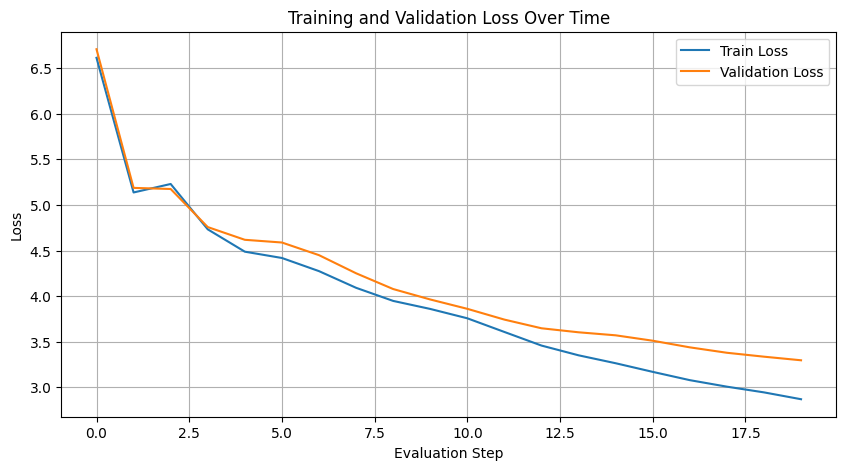

In [23]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Evaluation Step")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Over Time")
plt.legend()
plt.grid()
plt.show()

In [25]:
def get_input_tokens(message: str) -> torch.Tensor:
    input_tokens = tokenizer.encode(
        f"<|startoftext|>{message}<|separator|>", allowed_special="all")
    input_tokens = torch.tensor(
        input_tokens, dtype=torch.long).unsqueeze(0).to(device)
    return input_tokens


user_message = "hello"
input_tokens = get_input_tokens(message=user_message)
model_answer = ""

model.eval()
while True:
    output_tokens = model.generate(input_tokens=input_tokens, max_new_tokens=1)
    last_generated_token = output_tokens[0, -1].item()
    if last_generated_token == tokenizer.special_tokens["<|endoftext|>"]:
        break

    input_tokens = torch.cat((input_tokens, output_tokens[:, -1:]), dim=1)
    model_answer += tokenizer.decode([last_generated_token])

    if len(output_tokens[0]) > block_size:
        break

print(f"You: {user_message}")
print(f"Assistant: {model_answer}")

You: hello
Assistant: seem iyo teunga tha..Do Ba
-<|separator|>2= 0everll Ye � Not is son 1hat Hnn you , wYf Person 2<|separator|>Lere a 102)toh PertD �aathing Person things ya 2<|separator|>ye
2<|separator|>=ould ki the t ab jerson I inwas it gi w, �he 20️ 1/2g� ba 1<|separator|>Person ga G 120Sh2<|separator|>I hi hai w ki usghtoson 1 co hurgg 4\90] me 5 Nhi p🥹 W? �� son:2go�) that aaa😂 rooon parson it 1{<|startoftext|>Person na�right cata jerson ukitChl bhi uoa 1<|unk|> parson baday ndshi that one ly son t, A2te hai shi A/re worfDo son toersond 202[ye
KhoM 1ujhe th about bhi APerson 1enge Demega puferson ke Co krH 1<|separator|>hi mition d hn Yup 2<|separator|>Persony son 1te hai Mtalhbhlyi na: ing+tere dt gersw is usbhi 
